Install packages, Read in Data

In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import os
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import datetime
from sklearn.metrics import confusion_matrix 
#from sklearn.cross_validation import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

Read in data 

In [6]:
#Measurements 
signals = pd.read_csv('./signal.csv', header=0, delimiter=";", index_col=0)  
signals=signals.drop(signals.columns[[0]], axis=1, inplace=False)
signals= signals.sort_values(by=['pat_id'])
#signals

Read in Age df. There are 1495 unique patients. On average there are 67 measurements per patient. There are no missing value and no double entries for patients. 

In [7]:
age = pd.read_csv('./age.csv', header=0, delimiter=";", index_col=0) 
age= age.sort_values(by=['pat_id'])
missing_age_rows= len(age.loc[age['age'].isnull()])  # no missing values for age 
missing_age_rows
#print(len(age['pat_id'].unique())) # no double patient-ids


0

In [8]:
admission = pd.read_csv('./admission.csv', header=0, delimiter=";", index_col=0) 
print(len(admission['pat_id'].unique()))
admission= admission.sort_values(by=['pat_id'])

#admission


1495


### Extract features in admission and age

#### Days Since Admission
Change the dates to days since admission. I am assuming that the actual dates do not matter for predicting patient outcomes. 

In [9]:
#Calculate days spent in ICU
admission['date_admission']= pd.to_datetime(admission['date_admission'])
admission['date_discharge']= pd.to_datetime(admission['date_discharge'])
admission['days_spent_in_icu']= admission['date_discharge'] - admission['date_admission']
admission['days_spent_in_icu']= admission['days_spent_in_icu'].dt.days
#admission

In [41]:
#match age to each admission and fill in missing values
#there are 67 pat_ids that we cant match. its a but weird, cause the length of the ids is the same in admission and age  

# missing_age_adm= len(admission['pat_id'].unique())- len(age['pat_id'].unique())

# pat_ids= admission['pat_id'].unique()
# df= admission

# age_dict2={}
# pats_without_age=[]  

# for i in pat_ids:
#     indeces= df[df['pat_id']== i].index.tolist()  #gives at what indeces it comes up - the indeces are the measurements. 
#     age_k=age.loc[age['pat_id']==i, 'age'].values.tolist()
#     if len(age_k)!=1:
#         age_k= [60.0]  # before NAN now median age
#         pats_without_age.append(i)
#     for k in (range(len(indeces))):
#         age_dict2[indeces[k]]= age_k[0]
# #there is one outlier, and I think I would just get rid of the row.
# len(age_dict2)

# age_df2= pd.DataFrame.from_dict(age_dict2, orient='index')
# age_df2.columns=['age']

# admission_c= admission
# admission_c['age']= age_df2['age']

# print(admission_c)


In [10]:
#pandas alternative with merge, I think and then decide what to do with missing value. Left 

admission  = pd.merge(admission, age, on=['pat_id'], how='left').fillna('60')




#### Readmitted or Not
readmitted wil be our y dataset.
1492 out of 1566 patients are not readmitted. We have imbalanced classes, so we need to respect that later on. 

In [329]:
# pat_ids= admission['pat_id'].unique()
# df= admission
# dict={}
# readmitted={}

# for i in pat_ids:
#     indeces= df[df['pat_id']== i].index.tolist()  #gives at what indeces it comes up 
#     last_stay=len(indeces)
#     for k in (range(len(indeces))):
#         dict[indeces[k]]=k
#         if k+1 == last_stay:
#             readmitted[indeces[k]]=0
#         else:
#             readmitted[indeces[k]]=1

In [330]:
# readmitted= pd.DataFrame.from_dict(readmitted, orient='index')
# readmitted.columns=['readmitted']
# readmitted['admission_id']= admission.index

In [13]:
#Pandas alterntative again 
#readmitted groupby pat_id, count, put back in orginal order 
readmitted= admission.groupby('pat_id').cumcount().apply(lambda x: x if x==0 else 1 )
admission['readmitted']= readmitted
readmitted['admission_id']= admission.index #think unnecessary



0       0
1       0
2       0
3       0
4       0
       ..
1564    0
1565    0
1566    0
1567    0
1568    0
Length: 1569, dtype: int64
      pat_id date_admission date_discharge  days_spent_in_icu age  readmitted
0          0     2016-01-05     2016-01-07                  2  35           0
1          1     2014-07-04     2014-07-06                  2  77           0
2          3     2014-10-16     2014-10-20                  4  61           0
3          4     2015-02-06     2015-02-07                  1  27           0
4          5     2014-12-06     2014-12-08                  2  67           0
...      ...            ...            ...                ...  ..         ...
1564    1564     2016-07-29     2016-07-30                  1  87           0
1565    1565     2015-04-21     2015-04-22                  1  68           0
1566    1566     2015-01-10     2015-01-10                  0  73           0
1567    1567     2015-01-31     2015-02-01                  1  83           0
1568 

### Assign Admission id to measurments in signals 

In [14]:
#Assign admissionid to each row in signals
 
admission['admission_id']= admission.index

adm_ids=[]   #should maybe change to admission id
days_since_admission=[]

for index,row in signals.iterrows():
    #index has the info of where we are in signals 
    #get the admission data for the corresponding patient of the row we consider in signals
    actually_patient= admission.loc[(admission['pat_id']==row['pat_id'])]
    
    # find out to which stay (admission period) the row measurement corresponds to - assign admission id
    patient_visit= actually_patient.loc[(actually_patient['date_admission']<=row['day']) &(admission['date_discharge']>=row['day'])]
    adm_id=patient_visit['admission_id'].values.tolist()
    #some measurements are not within a registered admission period, so assign admission ID NA to those 
    if adm_id== []:
        adm_id= "NA"  
        days_since_adm= "NA"
    
    else:
        adm_id=adm_id[0]
        #get feature days since admission by comparing the day of the measurement with the day of admission 
        day_adm=patient_visit['date_admission'].values[0]
        day_adm= pd.to_datetime(day_adm).date()
        day_cur= pd.to_datetime(row['day']).date() 
        days_since_adm= day_cur- day_adm   #calculate timedelta
        days_since_adm= days_since_adm.days  #get no of days
    
    adm_ids.append(adm_id)
    days_since_admission.append(days_since_adm)



      pat_id date_admission date_discharge  days_spent_in_icu age  readmitted  \
0          0     2016-01-05     2016-01-07                  2  35           0   
1          1     2014-07-04     2014-07-06                  2  77           0   
2          3     2014-10-16     2014-10-20                  4  61           0   
3          4     2015-02-06     2015-02-07                  1  27           0   
4          5     2014-12-06     2014-12-08                  2  67           0   
...      ...            ...            ...                ...  ..         ...   
1564    1564     2016-07-29     2016-07-30                  1  87           0   
1565    1565     2015-04-21     2015-04-22                  1  68           0   
1566    1566     2015-01-10     2015-01-10                  0  73           0   
1567    1567     2015-01-31     2015-02-01                  1  83           0   
1568    1568     2016-01-18     2016-01-19                  1  64           0   

      admission_id  
0     

In [15]:
signals['admission_id']=adm_ids
signals['days_since_adm']= days_since_admission


In [333]:
print(signals)
#could also one hot encode parameters, leave value
signals.loc[signals['parameter'] == 'blood_pressure', 'blood_pressure'] = signals['value'] 
signals.loc[signals['parameter'] == 'respiration_rate', 'respiration_rate'] = signals['value'] 
signals.loc[signals['parameter'] == 'temperature', 'temperature'] = signals['value'] 
signals=signals.drop(columns=['parameter', 'value'])

### do feature engineering with the measurments (signals) 

After some inspection of the data, the blood pressure measurements are quite complex, and there are many measurements. 
Now we calculte min and max, median and standard deviation as features for blood pressure per stay. 
The temperature are usually only a few measurements, so probably the median is sufficient. 
Since there is a quite some variation in the data, the median is preferred over the mean. 
I have some open questions about the repiration data, as the values are mostly much lower than the normal range for adults. 
When visualising the measurements, we see that there are some potential outliers for blood pressure. However, these could also be the actual measurements and the reason why the patients are in the intensive care unit. 
Therefore we will not remove outliers at this point. (We could try it and compare the effects though)


In [334]:
import math
admission_ids= admission.index


measurements_per_adm=[]
bp_median_dict={}
bp_min_dict={}
bp_max_dict={}
bp_std_dict={}
temp_median_dict={}
temp_min_dict={}
temp_max_dict={}
resp_median_dict={}
resp_min_dict={}
resp_max_dict={}

for adm_id in admission_ids:
    visit= signals.loc[signals['admission_id']==adm_id]

# commented code for visualisatin 
#     with pd.option_context('display.max_rows', None, 'display.max_columns', None): # more options can be specified also 
#         print(visit)
#     measurement_no=range(len(visit))
#   visit['measurement_no']= measurement_no
    #measurements_per_adm.append(measurement_no)
    #meanbp=visit['blood_pressure'].mean(axis=0)
    
    
    median_bp=visit['blood_pressure'].median(axis=0)
    max_bp=visit['blood_pressure'].max(axis=0)
    min_bp=visit['blood_pressure'].min(axis=0)
    std_bp=visit['blood_pressure'].std(axis=0)
    #visit.plot(kind='scatter',x= ['measurement_no'], y='blood_pressure',color='red')
    bp_median_dict[adm_id]=median_bp
    bp_min_dict[adm_id]=min_bp
    bp_max_dict[adm_id]=max_bp
    bp_std_dict[adm_id]=std_bp
    #visit.plot(kind='scatter',x= ['measurement_no'], y='temperature',color='red')
    
    median_temp=visit['temperature'].median(axis=0)
    max_temp=visit['temperature'].max(axis=0)
    min_temp=visit['temperature'].min(axis=0)
#    visit.plot(kind='scatter',x= ['measurement_no'], y='temperature',color='red')
    temp_median_dict[adm_id]=median_temp
    temp_min_dict[adm_id]=min_temp
    temp_max_dict[adm_id]=max_temp
    


    #visit.plot(kind='scatter',x= ['measurement_no'], y='respiration_rate',color='red')
    median_resp=visit['respiration_rate'].median(axis=0)  #inspected data and median makes more sense to me 
    mean_resp=visit['respiration_rate'].mean(axis=0)
    max_resp=visit['respiration_rate'].max(axis=0)
    min_resp=visit['respiration_rate'].min(axis=0)
    resp_median_dict[adm_id]=median_resp
    resp_min_dict[adm_id]=min_resp
    resp_max_dict[adm_id]=max_resp




In [335]:
bp_median_df= pd.DataFrame.from_dict(bp_median_dict, orient='index')
bp_median_df.columns=['bp_median']
bp_min_df= pd.DataFrame.from_dict(bp_min_dict, orient='index')
bp_min_df.columns=['bp_min']
bp_max_df= pd.DataFrame.from_dict(bp_max_dict, orient='index')
bp_max_df.columns=['bp_max']
bp_std_df= pd.DataFrame.from_dict(bp_std_dict, orient='index')
bp_std_df.columns=['bp_std']

resp_median_df= pd.DataFrame.from_dict(resp_median_dict, orient='index')
resp_median_df.columns=['resp_median']
temp_median_df= pd.DataFrame.from_dict(temp_median_dict, orient='index')
temp_median_df.columns=['temp_median']

### Create first version of our X
Add all the relevant features in a new dataframe with each row representing one admission

In [336]:
new_x= admission
new_x= new_x.drop(columns=['pat_id', 'date_admission', 'date_discharge'])

new_x['bp_median']= bp_median_df['bp_median']
new_x['bp_min']= bp_min_df['bp_min']
new_x['bp_max']= bp_max_df['bp_max']
new_x['bp_std']= bp_std_df['bp_std']

new_x['resp_median']= resp_median_df['resp_median']
new_x['temp_median']= temp_median_df['temp_median']

### Outlier detection and Missing values 

### Check missing values - Fill or remove
#normal blood pressure 120-139
#normal temp 37 (36-37), fever from 38 
#normal respiratory rate 12-20 , depends on age - so a bit strange that the respitation rate is often around 2 
#there are also some outliers that need to be fixed actually - bp 500 
#drop 8 rows where we don't have age data.

In [337]:
new_x
# new_x['bp_median'].median()
# new_x['bp_max'].median()
# new_x['bp_min'].median()
# new_x['bp_min'].median()
# new_x['temp_median'].mean()
#new_x['resp_median'].mean()

#check if rows have 3 or more NAs- so no measurements were taken and remove them. We remove 61 rows. 
indeces_no_measurements= new_x.loc[new_x.isnull().sum(axis=1) >=3].index
old_x= new_x
new_x= new_x.drop(indeces_no_measurements)


In [381]:
#check for negative (impossible) values. Found none
data= new_x
indeces=[]
for cols in data.columns[1:]:
    data = data.loc[data[cols] <0]
    indeces.append(data.index)


#Extreme outliers
Highest recorded blood pressure was 360. This corresponds to a threshold of 3 standard deviations.
We keep a threshold of 3 standard deviations for outlier detection. 
For blood pressure, we found 45 admissions with outliers. 

For temperature, we dont perform any removal of outliers. There are only 2 values 35 and 39 that could maybe be physiological. 
Respiratory rate I am not sure about. There are 81 measurements that are classified as outliers. These are all around a value of 20 which is within the physiological adult range. The mean however is 6 (below the physiological range). I chose not to remove the measurements.



In [390]:
#unction for outlier detection
outliers=[]
outlier_index=[]
def detect_outlier(df, column):
    
    
    threshold=3
    mean_1 =df[column].mean().tolist()[0]
    std_1 =df[column].std().tolist()[0]
    
    for index,row in df.iterrows():
    #index has the ifo of where we are in signals 
        y= row[column].tolist()[0]
        z_score= (y- mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(row[column])
            outlier_index.append(index)
            
    return outliers,outlier_index



In [392]:
#Outlier Blood Presssure  
outlier_index_bp_max= detect_outlier(data, column=['bp_max'])[1]
outlier_index_bp_min= detect_outlier(new_x, column=['bp_min'])[1]
outlier_bp_median, outlier_index_bp_median= detect_outlier(new_x, column=['bp_median'])

outlier_index_bp=list(set(outlier_index_bp_max+ outlier_index_bp_min+ outlier_index_bp_median))
new_x= new_x.drop(index=outlier_index_bp)

In [391]:
#Outlier Respiration
outlier_resp_median, outlier_index_resp_median= detect_outlier(new_x, column=['resp_median'])
print(outlier_resp_median)
print(len(outlier_resp_median))
# new_x1=new_x.drop(outlier_index_resp_median)


[resp_median    23.99
Name: 22787, dtype: float64, resp_median    19.99
Name: 23179, dtype: float64, resp_median    20.0
Name: 23900, dtype: float64, resp_median    20.0
Name: 20091, dtype: float64, resp_median    20.0
Name: 22080, dtype: float64, resp_median    20.01
Name: 23787, dtype: float64, resp_median    20.01
Name: 23413, dtype: float64, resp_median    20.005
Name: 19645, dtype: float64, resp_median    23.99
Name: 19664, dtype: float64, resp_median    29.99
Name: 23261, dtype: float64, resp_median    19.99
Name: 19926, dtype: float64, resp_median    19.99
Name: 19548, dtype: float64, resp_median    24.0
Name: 22508, dtype: float64, resp_median    19.995
Name: 20398, dtype: float64, resp_median    29.99
Name: 23664, dtype: float64, resp_median    19.99
Name: 20538, dtype: float64, resp_median    19.995
Name: 23734, dtype: float64, resp_median    20.0
Name: 19499, dtype: float64, resp_median    19.99
Name: 19587, dtype: float64, resp_median    20.01
Name: 22318, dtype: float64, r

#### Missing values

In [383]:
# For the remainder, we assume that the measurements were not taken, because it didnt seem necessary. 
#I will drop the rows where the respiration rate was not recorded, because I am unsure how to fill it and it is only 43 rows. 

new_x['bp_median']= new_x['bp_median'].fillna(130.0)
new_x['bp_min']= new_x['bp_min'].fillna(120.0)
new_x['bp_max']= new_x['bp_max'].fillna(140.0)
new_x['temp_median']= new_x['temp_median'].fillna(37.0)
new_x['bp_std']= new_x['bp_std'].fillna(new_x['bp_std'].mean())

#respiration rate
#new_x['resp_median']= new_x['resp_median'].fillna(12.0)
no_resp_indeces= new_x.loc[new_x['resp_median'].isnull()].index# 43 admissions without respiration rate recorded
new_x= new_x.drop(no_resp_indeces)



### Create the final datasets for model generation

In [393]:
#import the necessary module
from sklearn import preprocessing
#combined dataset
dataset = pd.merge(readmitted, new_x, on=['admission_id'], how='inner')
dataset= dataset.drop(columns=['admission_id'])
dataset_copy = dataset.copy()
X= dataset_copy
Y= X.pop('readmitted')
# create the Labelencoder object
le = preprocessing.LabelEncoder()
#convert the categorical columns into numeric
Y = le.fit_transform(Y)
Y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

#### Oversampling datasets
I tried oversampling and Undersampling. Undersampling doesnt work, because then the test and training sets are too small. For example the test set would be 40 samples not 440. 
Oversampling resulted in a lower performance of the models. The oversampling might cause some overfitting. 

In [394]:
from imblearn.over_sampling import RandomOverSampler   
rus = RandomOverSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, Y)
X_resampled= pd.DataFrame(X_resampled)
X_resampled.columns = list(X.columns)


### Split data intp training and test set. 


In [395]:
#X_train, X_test, y_train, y_test = train_test_split( X_resampled, y_resampled, test_size = 0.3, random_state = 100) 

In [396]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100) 

### Classification Algorithms. 

In [397]:
#Decision tree functions with balanced class weights. 

# Function to perform training with entropy. 
def train_using_entropy(X_train, X_test, y_train): 

	# Decision tree with entropy 
	clf_entropy = DecisionTreeClassifier( 
			criterion = "entropy", random_state = 100, 
			max_depth = 3, min_samples_leaf = 5, class_weight= "balanced" ) #

	# Performing training 
	clf_entropy.fit(X_train, y_train) 
	return clf_entropy 


# Function to make predictions 
def prediction(X_test, clf_object): 

	# Predicton on test with giniIndex 
	y_pred = clf_object.predict(X_test) 
# 	print("Predicted values:") 
#	print(y_pred) 
	return y_pred 

In [398]:
#Standard Neural Network. No class weighting possible 
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

#Normal neural net
def feedforward_neural_network( train_X, train_y, test_X, hidden_layer_sizes=(3,), max_iter=500, activation='logistic', alpha=0.001, learning_rate='adaptive', print_model_details=False):


        # Create the model
        nn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, max_iter=max_iter, learning_rate=learning_rate, alpha=alpha)

        # Fit the model
        nn.fit(train_X, train_y.ravel())

        # Apply the model
        pred_prob_training_y = nn.predict_proba(train_X)
        pred_prob_test_y = nn.predict_proba(test_X)
        pred_training_y = nn.predict(train_X)
        pred_test_y = nn.predict(test_X)
        frame_prob_training_y = pd.DataFrame(pred_prob_training_y, columns=nn.classes_)
        frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=nn.classes_)

        return (pred_test_y, pred_training_y)  #, pred_test_y, frame_prob_training_y, frame_prob_test_y

In [399]:
#SVM we can make balanced. Here we also implemented a grid search. 
#from sklearn import svm
from sklearn.svm import SVC
def support_vector_machine_with_kernel(train_X, train_y, test_X, kernel='rbf', C=1, gamma=1e-3, gridsearch=False, print_model_details=False):
    # Create the model
    if gridsearch:
        tuned_parameters = [{'kernel': ['rbf', 'poly'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 50]}]
        svm = GridSearchCV(SVC(probability=True), tuned_parameters, cv=3, scoring='accuracy')
    else:
        svm = SVC(C=C, kernel=kernel, gamma=gamma, probability=True, cache_size=7000, class_weight='balanced')

    # Fit the model
    svm.fit(train_X, train_y.ravel())

    if gridsearch and print_model_details:
        print(svm.best_params_)

    if gridsearch:
        svm = svm.best_estimator_

    # Apply the model
    pred_prob_training_y = svm.predict_proba(train_X)
    pred_prob_test_y = svm.predict_proba(test_X)
    pred_training_y = svm.predict(train_X)
    pred_test_y = svm.predict(test_X)
    frame_prob_training_y = pd.DataFrame(pred_prob_training_y, columns=svm.classes_)
    frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=svm.classes_)

    return (pred_test_y, pred_training_y) #pred_training_y, pred_test_y, frame_prob_training_y, frame_prob_test_y


In [400]:
#XGBoost with weighted classes. 

from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

def xgboost(X_train, y_train, X_test):

    # define model
    xgb = XGBClassifier(scale_pos_weight=99)
    # define grid
    weights = [1, 10, 25, 50, 75, 99, 100, 1000]
    param_grid = {}
    param_grid['scale_pos_weight']=weights
    
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define grid search
    grid = GridSearchCV(estimator=xgb, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')  
    # execute the grid search
    grid_result = grid.fit(X_train, y_train)
    #scores = cross_val_score(xgb, X_test, y_test, scoring='f1', cv=cv, n_jobs=-1)
    print(grid.best_params_)
    
    pred_train_y = grid_result.predict(X_train)
    pred_test_y = grid_result.predict(X_test)
    
    return(pred_test_y, pred_train_y)
    


### Feature Selection 
We select which features to include in our final models. We use the F1 score instead of accuracy to evaluate models. 

In [401]:
import copy
from matplotlib.pyplot import *
import sklearn.metrics as metrics

# Specifies feature selection approaches for classification to identify the most important features.
class FeatureSelectionClassification:

    # Forward selection for classification which selects a pre-defined number of features (max_features)
    # that show the best accuracy. We assume a decision tree learning for this purpose, but
    # this can easily be changed. It return the best features.
    def forward_selection(self, max_features, X_train, y_train):
        # Start with no features.
        ordered_features = []
        ordered_scores = []
        selected_features = []
        
        prev_best_perf = 0

        # Select the appropriate number of features.
        for i in range(0, max_features):

            #Determine the features left to select.
            features_left = list(set(X_train.columns) - set(selected_features))
            #print(features_left)
            best_perf = 0
            best_attribute = ''

            # For all features we can still select...
            for f in features_left:
                temp_selected_features = copy.deepcopy(selected_features)
                temp_selected_features.append(f)
                print(temp_selected_features)
                
                #Can do feature selection with the various algorithms. 

                # Determine the accuracy of a decision tree learner if we were to add
#                 # Decision tree
#                 clf_fit= train_using_entropy(X_train[temp_selected_features], X_test[temp_selected_features], y_train)
#                 y_pred = prediction(X_test[temp_selected_features], clf_fit)# ce.accuracy(y_train, pred_y_train)
#                 perf= metrics.f1_score(y_test, y_pred, average= "weighted")
                
#                 #Normal Neural net, problem no weighted classes
#                 y_pred = feedforward_neural_network(X_train[temp_selected_features], y_train, X_test[temp_selected_features])[0]
#                 perf= metrics.f1_score(y_test, y_pred, average= "weighted")
                
                #SVM with kernel, without grid search it takes ages
#                 y_pred = support_vector_machine_with_kernel(X_train[temp_selected_features], y_train, X_test[temp_selected_features])[0]
#                 perf= metrics.f1_score(y_test, y_pred, average= "weighted")

#                 #XGBoost
                y_pred = xgboost(X_train[temp_selected_features], y_train, X_test[temp_selected_features])[0]
                perf= metrics.f1_score(y_test, y_pred, average= "weighted")
    
                
                print(confusion_matrix(y_test, y_pred))
                
                # If the performance is better than what we have seen so far (we aim for high accuracy)
                # we set the current feature to the best feature and the same for the best performance.
                if perf > best_perf:
                    best_perf = perf
                    best_feature = f
            # We select the feature with the best performance.
            selected_features.append(best_feature)
            prev_best_perf = best_perf
            ordered_features.append(best_feature)
            ordered_scores.append(best_perf)
        return selected_features, ordered_features, ordered_scores


['bp_std']
{'scale_pos_weight': 50}
[[270 157]
 [ 10   3]]
['bp_median']
{'scale_pos_weight': 1000}
[[122 305]
 [  5   8]]
['days_spent_in_icu']
{'scale_pos_weight': 10}
[[387  40]
 [ 10   3]]
['bp_max']
{'scale_pos_weight': 1000}
[[143 284]
 [  2  11]]
['resp_median']


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 10}
[[375  52]
 [ 11   2]]
['age']
{'scale_pos_weight': 25}
[[142 285]
 [  2  11]]
['temp_median']


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 25}
[[293 134]
 [ 11   2]]
['bp_min']
{'scale_pos_weight': 1000}
[[151 276]
 [  6   7]]
['days_spent_in_icu', 'bp_std']
{'scale_pos_weight': 50}
[[265 162]
 [ 11   2]]
['days_spent_in_icu', 'bp_median']


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 10}
[[402  25]
 [ 11   2]]
['days_spent_in_icu', 'bp_max']
{'scale_pos_weight': 99}
[[239 188]
 [  7   6]]
['days_spent_in_icu', 'resp_median']


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 100}
[[ 52 375]
 [  4   9]]
['days_spent_in_icu', 'age']
{'scale_pos_weight': 1000}
[[ 70 357]
 [  2  11]]
['days_spent_in_icu', 'temp_median']


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 25}
[[324 103]
 [ 10   3]]
['days_spent_in_icu', 'bp_min']
{'scale_pos_weight': 10}
[[383  44]
 [ 13   0]]
['days_spent_in_icu', 'bp_median', 'bp_std']


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 50}
[[257 170]
 [ 10   3]]
['days_spent_in_icu', 'bp_median', 'bp_max']
{'scale_pos_weight': 25}
[[328  99]
 [ 11   2]]
['days_spent_in_icu', 'bp_median', 'resp_median']


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 99}
[[145 282]
 [  7   6]]
['days_spent_in_icu', 'bp_median', 'age']


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 1000}
[[122 305]
 [  6   7]]
['days_spent_in_icu', 'bp_median', 'temp_median']


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 100}
[[193 234]
 [ 11   2]]
['days_spent_in_icu', 'bp_median', 'bp_min']


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 1000}
[[117 310]
 [  5   8]]
['days_spent_in_icu', 'bp_median', 'bp_max', 'bp_std']


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 25}
[[320 107]
 [ 12   1]]
['days_spent_in_icu', 'bp_median', 'bp_max', 'resp_median']
{'scale_pos_weight': 75}
[[260 167]
 [  8   5]]
['days_spent_in_icu', 'bp_median', 'bp_max', 'age']


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 75}
[[261 166]
 [  7   6]]
['days_spent_in_icu', 'bp_median', 'bp_max', 'temp_median']


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 25}
[[355  72]
 [ 13   0]]
['days_spent_in_icu', 'bp_median', 'bp_max', 'bp_min']
{'scale_pos_weight': 99}
[[251 176]
 [  9   4]]
['days_spent_in_icu', 'bp_median', 'bp_max', 'temp_median', 'bp_std']
{'scale_pos_weight': 99}
[[282 145]
 [ 10   3]]
['days_spent_in_icu', 'bp_median', 'bp_max', 'temp_median', 'bp_min']
{'scale_pos_weight': 75}
[[295 132]
 [ 10   3]]
['days_spent_in_icu', 'bp_median', 'bp_max', 'temp_median', 'resp_median']


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 50}
[[302 125]
 [ 11   2]]
['days_spent_in_icu', 'bp_median', 'bp_max', 'temp_median', 'age']


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 25}
[[348  79]
 [ 13   0]]
['days_spent_in_icu', 'bp_median', 'bp_max', 'temp_median', 'age', 'bp_std']


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 10}
[[412  15]
 [ 12   1]]
['days_spent_in_icu', 'bp_median', 'bp_max', 'temp_median', 'age', 'bp_min']
{'scale_pos_weight': 99}
[[261 166]
 [  8   5]]
['days_spent_in_icu', 'bp_median', 'bp_max', 'temp_median', 'age', 'resp_median']


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 25}
[[343  84]
 [ 13   0]]
['days_spent_in_icu', 'bp_median', 'bp_max', 'temp_median', 'age', 'bp_std', 'bp_min']


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 50}
[[320 107]
 [ 10   3]]
['days_spent_in_icu', 'bp_median', 'bp_max', 'temp_median', 'age', 'bp_std', 'resp_median']


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 25}
[[354  73]
 [ 11   2]]
['days_spent_in_icu', 'bp_median', 'bp_max', 'temp_median', 'age', 'bp_std', 'resp_median', 'bp_min']
{'scale_pos_weight': 50}
[[312 115]
 [ 11   2]]
['days_spent_in_icu', 'bp_median', 'bp_max', 'temp_median', 'age', 'bp_std', 'resp_median', 'bp_min']
[0.9147333249274997, 0.93181818181818199, 0.8321309147542485, 0.86669525443110351, 0.85715274573142597, 0.94170218330638122, 0.86887052341597781, 0.80832727272727267]


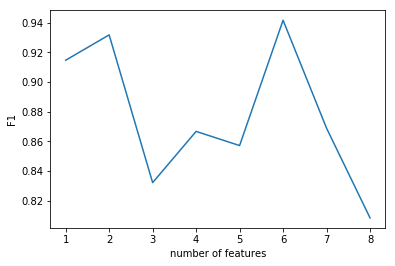

In [402]:
#Visualise Results from Feature Selection 

fs = FeatureSelectionClassification()
features, ordered_features, ordered_scores = fs.forward_selection(8, X_train, y_train) #(50, train_X[features_after_chapter_5], train_y)
print(ordered_features)
print(ordered_scores)

import matplotlib.pyplot as plot

plot.plot(range(1,9), ordered_scores)
plot.xlabel('number of features')
plot.ylabel('F1')
plot.show()


### Train and test the actual model with selected features

In [408]:
selected_features=['days_spent_in_icu', 'bp_median', 'bp_max', 'temp_median', 'age', 'bp_std']
selected_train_X=X_train[selected_features]
selected_test_X= X_test[selected_features]

In [409]:
# Test the most promising classification algortihms which were XGBoost and the SVM. Run three times and get the average performance on training and test set. 
repeats=3

performance_ts_xgb=0
performance_tr_xgb=0

performance_ts_svm=0
performance_tr_svm=0

for repeat in range(0, repeats):
        y_pred_test, y_pred_train  = xgboost(selected_train_X, y_train, selected_test_X)
        performance_ts_xgb+= metrics.f1_score(y_test, y_pred_test, average= "weighted")
        performance_tr_xgb+= metrics.f1_score(y_train, y_pred_train, average= "weighted")

        y_pred_test, y_pred_train  = support_vector_machine_with_kernel(selected_train_X, y_train, selected_test_X)
        performance_ts_svm+= metrics.f1_score(y_test, y_pred_test, average= "weighted")
        performance_tr_svm+= metrics.f1_score(y_train, y_pred_train, average= "weighted")
        
performance_ts_xgb= performance_ts_xgb/repeats
performance_tr_xgb= performance_tr_xgb/repeats

performance_ts_svm= performance_ts_svm/repeats
performance_tr_svm= performance_tr_svm/repeats

print("Performance XGBoost Training Vs. Test F1 score")
print(performance_tr_xgb, performance_ts_xgb)
print("Performance SVM Training Vs. Test F1 score")
print(performance_tr_svm, performance_ts_svm)


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 10}


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 10}


C:\Users\doyle\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'scale_pos_weight': 10}
Performance XGBoost Training Vs. Test F1 score
0.972140378071 0.941702183306
Performance SVM Training Vs. Test F1 score
0.785366204861 0.748728057053


So the best performance overall we found with XGBoost and an implemented grid search. So the best performance overall we found with XGBoost and an implemented grid search. 
The results still seem quite high to me, so maybe there is some overfitting going on. We could add some regularisation. 
4 Features were selected, which included a measure of the blood pressure and the respiration rate, as well as age and days spent in the ICU during the admision of the patient. Age and days_since_admission are risk factors. 
The results of the model were  better without removing the blood pressure outliers (that were physiological). 